# Data Preparation
### Data Description
#### Importing Packages

Here, we import the necessary Packages

In [1]:
import numpy as np
import nibabel as nib                                                     
#import itk                                                                
#import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate # Using Basic Image agumentation techniques will receive Fake Images 
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
%matplotlib inline
import seaborn as sns

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

## Import Train and validation path

Text(0.5, 1.0, 'Mask')

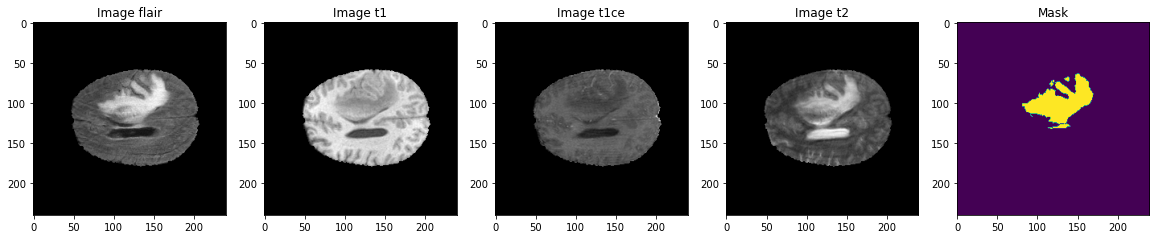

In [2]:
TRAIN_DATASET_PATH = 'D:/Projects/1138/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'D:/Projects/1138/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


In [3]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128 
VOLUME_START_AT = 22 # first slice of volume that we will include



total count: 1315928


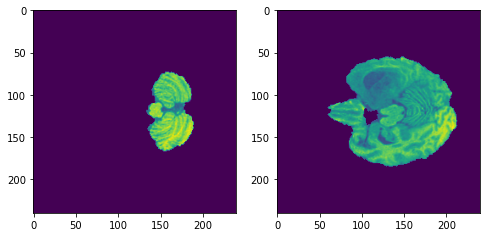

In [4]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(r'D:\Projects\1138\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

Show whole nifti data -> print each slice from 3d data

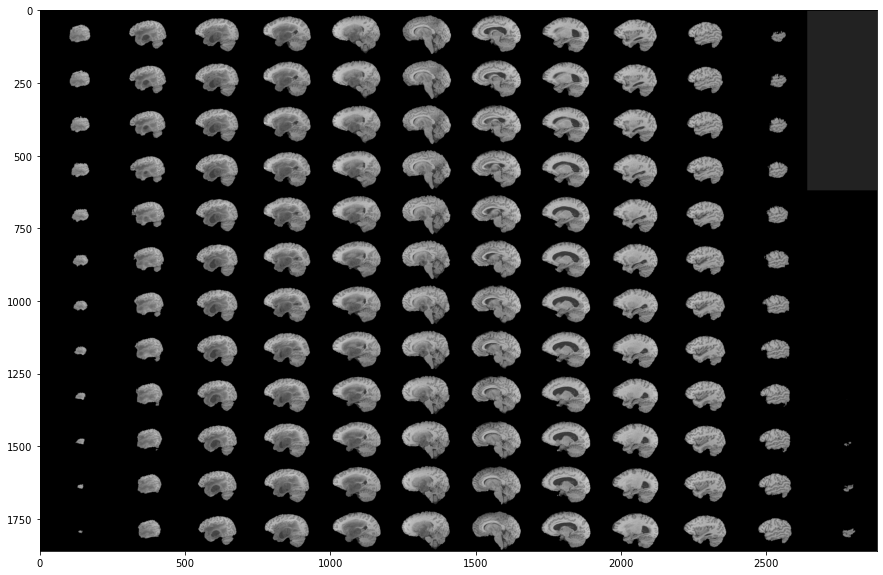

In [5]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

Show segment of tumor for each above slice

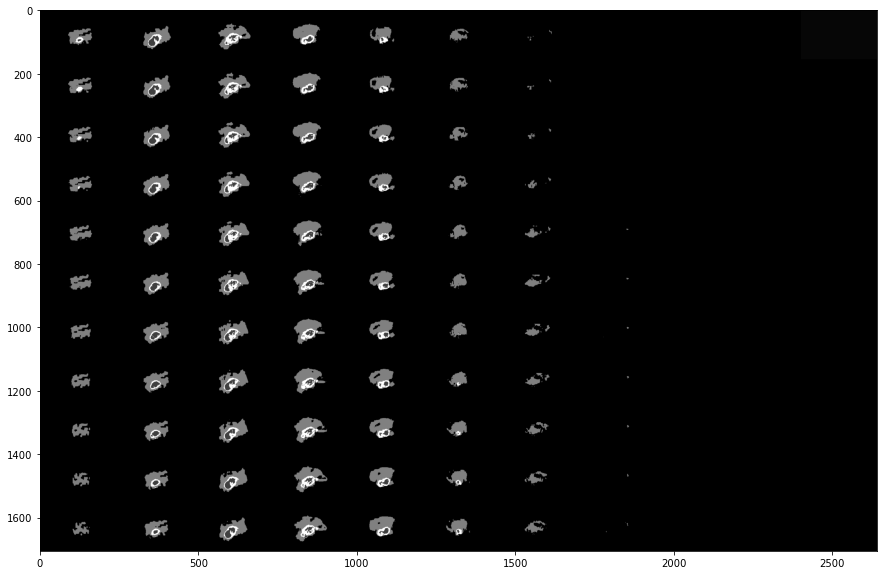

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

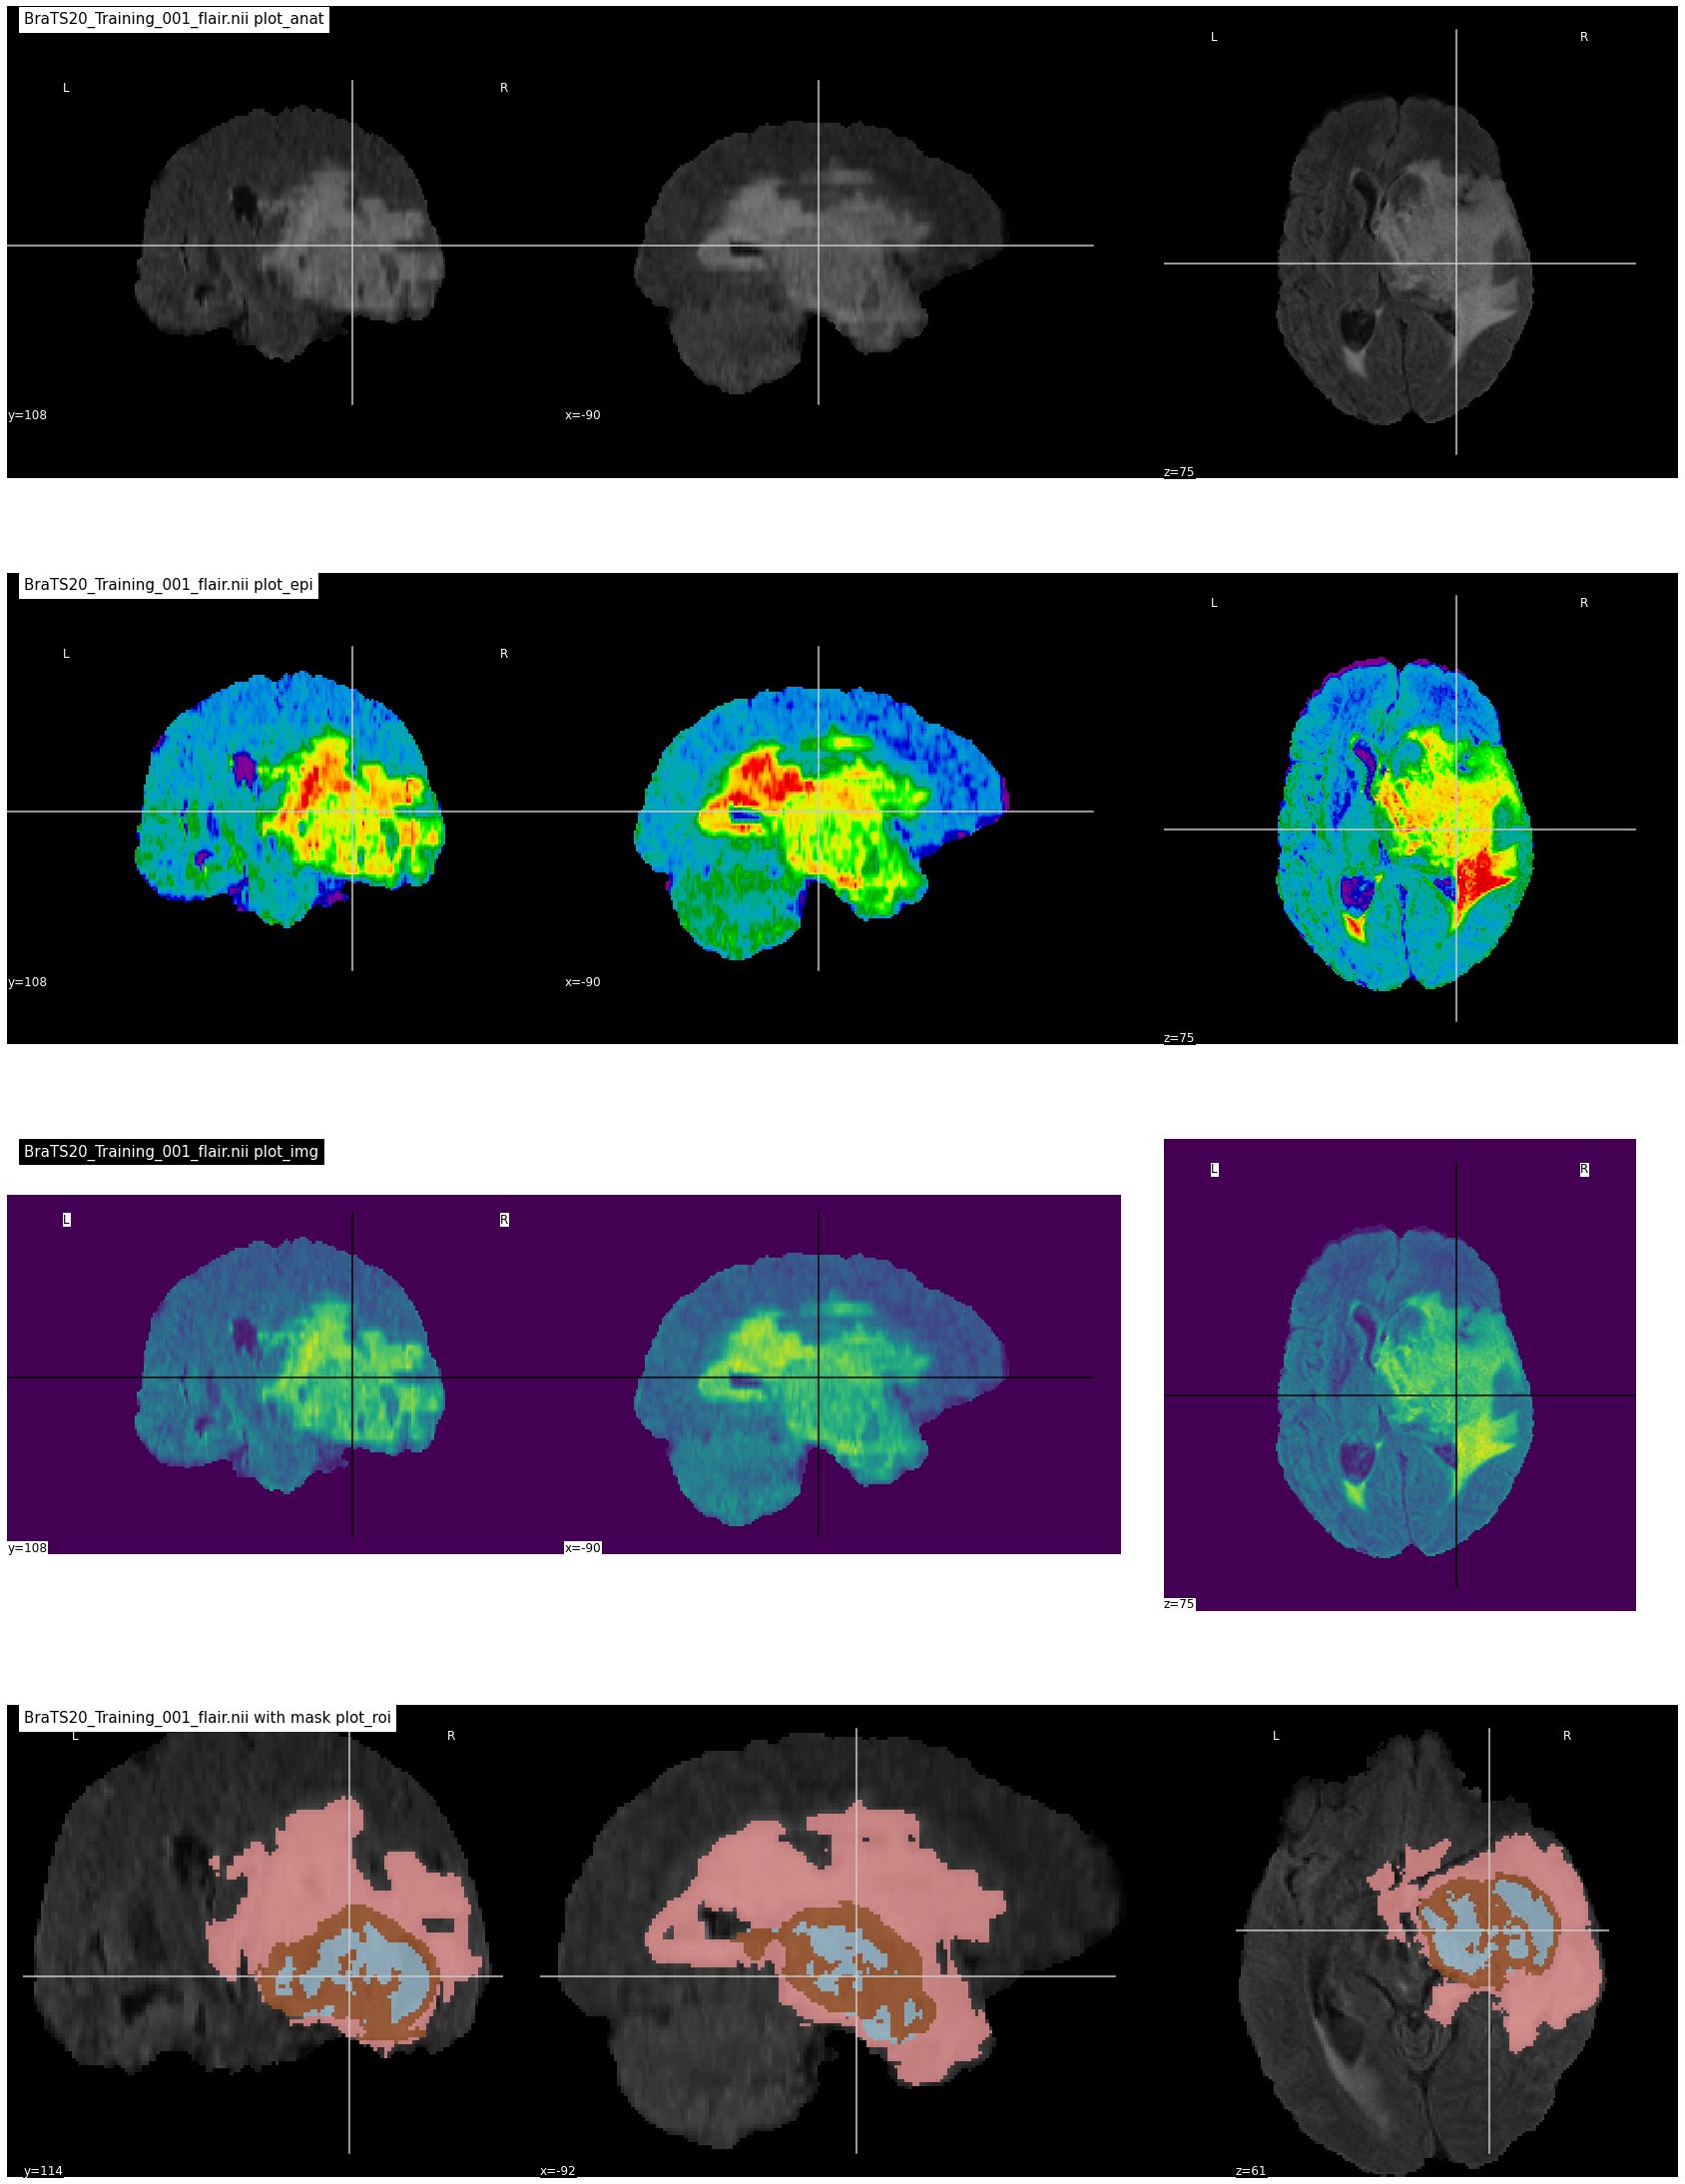

In [7]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [8]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Proposed Model 3dVnet

In [9]:
IMG_SIZE=128

In [10]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
    
  X = add([input_mat,X]);
  
  return X


def Vnet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  #c1 = conv_block(input_img,n_filters,3,batch_norm)
  c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  #c1 = add([c1,input_img])
  
  c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
  
  c3 = conv_block(c2 , n_filters*2,5,True)
  
  p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3, n_filters*4,5,True)
  p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
  p4 = Dropout(dropout)(p4)
    
  c5 = conv_block(p4, n_filters*8,5,True)
  p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
  p6 = Dropout(dropout)(p6)
  #c6 = conv_block(p5, n_filters*8,5,True)
  #p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c6)

  p7 = conv_block(p6,n_filters*16,5,True)
    
  u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
  u6 = concatenate([u6,c5]);
  c7 = conv_block(u6,n_filters*16,5,True)
  c7 = Dropout(dropout)(c7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);

  
  u8 = concatenate([u7,c4]);
  c8 = conv_block(u8,n_filters*8,5,True)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);
    
  u9 = concatenate([u9,c3]);
  c9 = conv_block(u9,n_filters*4,5,True)
  c9 = Dropout(dropout)(c9)
  u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);
  
  
  u10 = concatenate([u10,c1]);
  c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
  c10 = Dropout(dropout)(c10)
  c10 = add([c10,u10]);
  
  

  #c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [11]:
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))

model = Vnet_3d(input_layer)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                            dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  2008        ['input_1[0][0]']                
                                8, 8)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   1040        ['conv3d[0][0]']                 
                                16)                                                           

                                                                                                  
 add_2 (Add)                    (None, 16, 16, 16,   0           ['dropout_1[0][0]',              
                                64)                               'activation_5[0][0]']           
                                                                                                  
 conv3d_10 (Conv3D)             (None, 8, 8, 8, 128  65664       ['add_2[0][0]']                  
                                )                                                                 
                                                                                                  
 dropout_2 (Dropout)            (None, 8, 8, 8, 128  0           ['conv3d_10[0][0]']              
                                )                                                                 
                                                                                                  
 conv3d_11

                                64)                                                               
                                                                                                  
 add_5 (Add)                    (None, 32, 32, 32,   0           ['concatenate_1[0][0]',          
                                64)                               'activation_11[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 32, 32, 32,   0           ['add_5[0][0]']                  
                                64)                                                               
                                                                                                  
 conv3d_transpose_2 (Conv3DTran  (None, 64, 64, 64,   8208       ['dropout_4[0][0]']              
 spose)                         16)                                                               
          

In [12]:
import os
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [13]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No handles with labels found to put in legend.


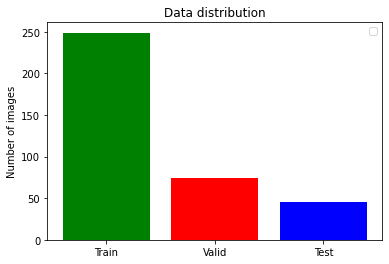

In [14]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [15]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

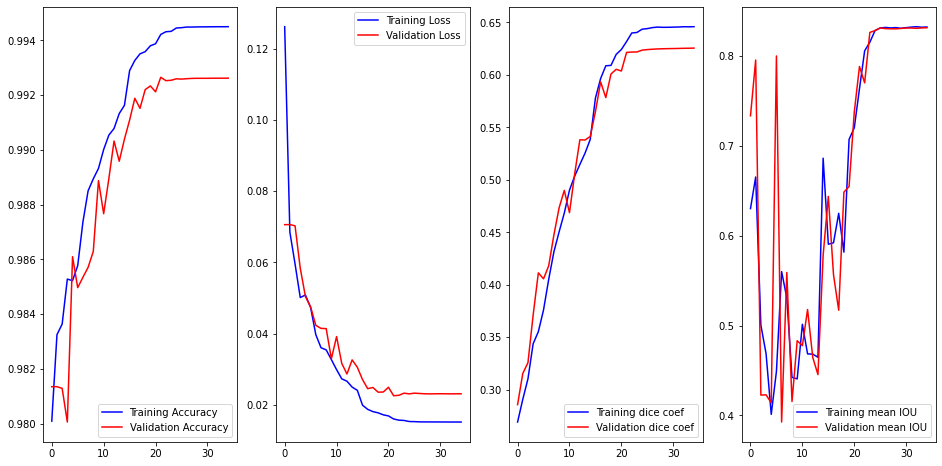

In [16]:
import pandas as pd
############ load trained model ################
model = keras.models.load_model('model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [17]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


4/4 [==============================] - 5s 1s/step


<Figure size 1296x3600 with 0 Axes>

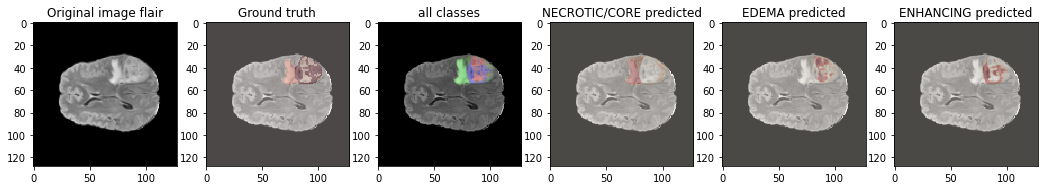

4/4 [==============================] - 4s 1s/step


<Figure size 1296x3600 with 0 Axes>

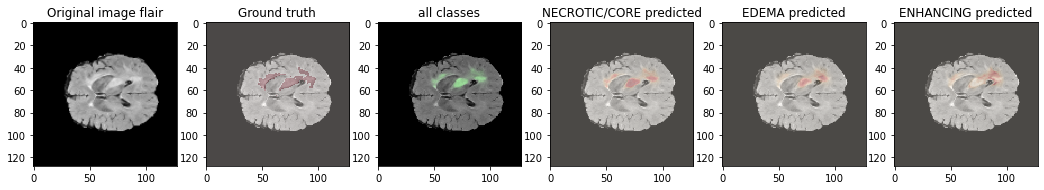

4/4 [==============================] - 4s 1s/step


<Figure size 1296x3600 with 0 Axes>

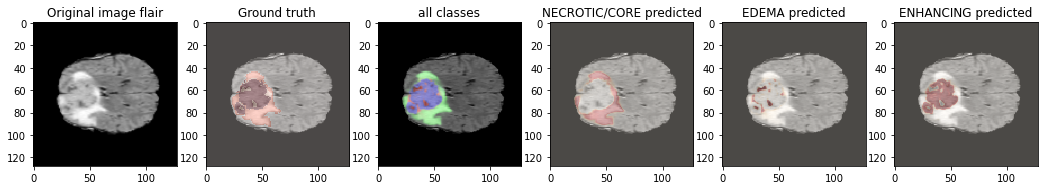

4/4 [==============================] - 4s 1s/step


<Figure size 1296x3600 with 0 Axes>

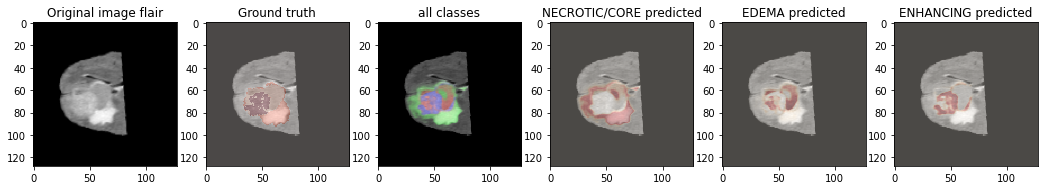

4/4 [==============================] - 4s 1s/step


<Figure size 1296x3600 with 0 Axes>

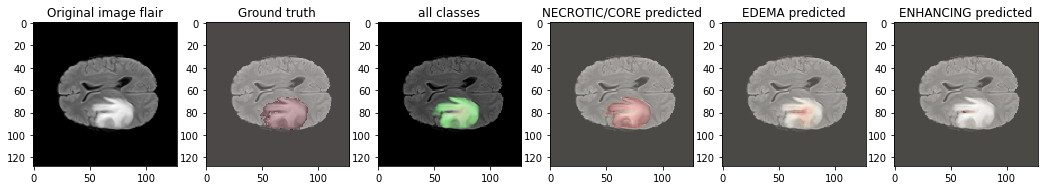

4/4 [==============================] - 4s 1s/step


<Figure size 1296x3600 with 0 Axes>

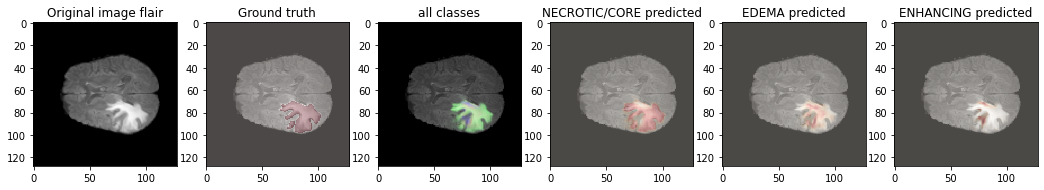

4/4 [==============================] - 4s 1s/step


<Figure size 1296x3600 with 0 Axes>

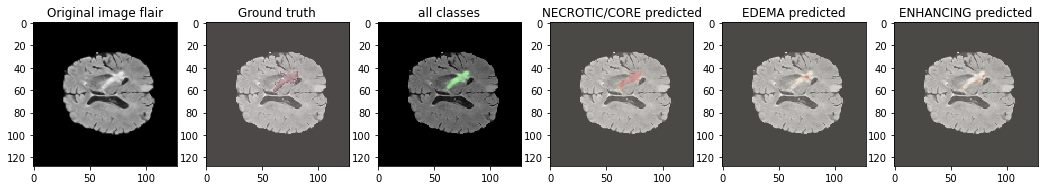

In [18]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

4/4 [==============================] - 4s 1s/step


<Figure size 432x288 with 0 Axes>

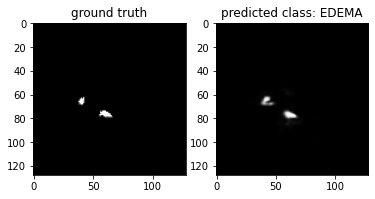

In [19]:
case = case=test_ids[3][-3:]
path = f"BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('Ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'Predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [20]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
Vnet_results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", Vnet_results)

Evaluate on test data
45/45 [==============================] - 250s 6s/step - loss: 0.0121 - accuracy: 0.9959 - mean_io_u_2: 0.8520 - dice_coef: 0.6526 - precision: 0.9960 - sensitivity: 0.9948 - specificity: 0.9986 - dice_coef_necrotic: 0.5979 - dice_coef_edema: 0.8217 - dice_coef_enhancing: 0.7488
test loss, test acc: [0.01208031177520752, 0.9958704710006714, 0.8520182371139526, 0.6525794267654419, 0.9960004091262817, 0.9947634339332581, 0.9986453652381897, 0.5978754758834839, 0.8217461705207825, 0.7488401532173157]


In [21]:
Vnet_Accuracy=Vnet_results[1]
print("Vnet_Accuracy ===>", Vnet_Accuracy)

Vnet_Accuracy ===> 0.9958704710006714


In [22]:
Vnet_Loss=Vnet_results[0]
print("Vnet_Loss ===>", Vnet_Loss)

Vnet_Loss ===> 0.01208031177520752


In [23]:
Vnet_mean_iou=Vnet_results[2]
print("Vnet_mean_iou ===>", Vnet_mean_iou)

Vnet_mean_iou ===> 0.8520182371139526


In [24]:
Vnet_precision=Vnet_results[4]
print("Vnet_precision ===>", Vnet_precision)

Vnet_precision ===> 0.9960004091262817


In [25]:
Vnet_sensitivity=Vnet_results[5]
print("Vnet_sensitivity ===>", Vnet_sensitivity)

Vnet_sensitivity ===> 0.9947634339332581


In [26]:
Vnet_specificity=Vnet_results[6]
print("Vnet_specificity ===>", Vnet_specificity)

Vnet_specificity ===> 0.9986453652381897


# Existing Model with Unet

In [27]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(256,1,2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    conv7 = concatenate([conv7,conv71], axis = 3)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(128,1,2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv81)
    conv8 = concatenate([conv8,conv81], axis = 3)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(64,1,2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv91)
    conv9 = concatenate([conv9,conv91], axis = 3)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(32,1,2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    conv = concatenate([conv,conv1], axis = 3)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [28]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [29]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [30]:
#%%time

##Model trained and saved

#K.clear_session()

#history =  model.fit(training_generator,
                  #  epochs=3,batch_size=1024,
                  #  steps_per_epoch=len(train_ids),
                  #  callbacks= callbacks,
                  #  validation_data = valid_generator
                  #  )  
#model.save("model_x1_1.h5")

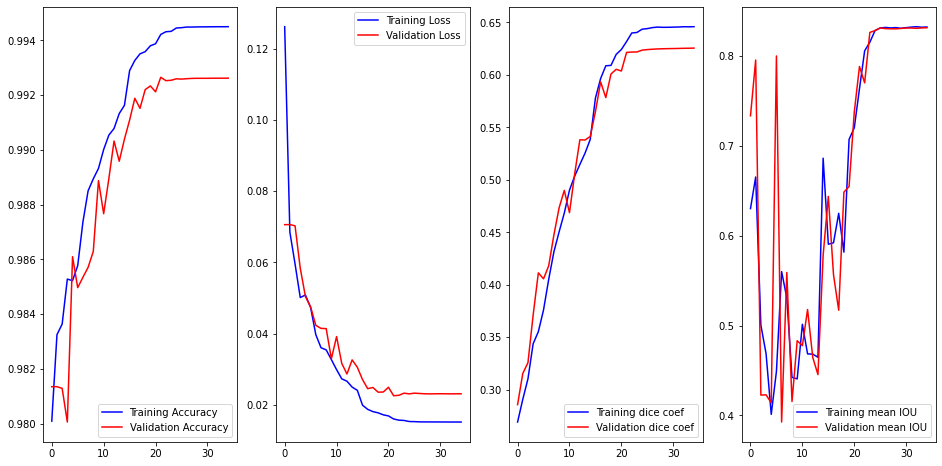

In [31]:
import pandas as pd
############ load trained model ################
model = keras.models.load_model('model_x1_1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [32]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
U_net_results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", U_net_results)

Evaluate on test data
45/45 [==============================] - 392s 9s/step - loss: 0.0564 - accuracy: 0.9868 - mean_io_u_5: 0.3889 - dice_coef: 0.3009 - precision: 0.9909 - sensitivity: 0.9832 - specificity: 0.9970 - dice_coef_necrotic: 0.1533 - dice_coef_edema: 0.2686 - dice_coef_enhancing: 0.1959
test loss, test acc: [0.05640295520424843, 0.9867770075798035, 0.3888672888278961, 0.30094683170318604, 0.9909231662750244, 0.9831539392471313, 0.9969555139541626, 0.1533302366733551, 0.2685738801956177, 0.19591887295246124]


In [33]:
U_net_accuracy=U_net_results[1]
print("U_net_accuracy ===>", U_net_accuracy)

U_net_accuracy ===> 0.9867770075798035


In [34]:
U_net_Loss=U_net_results[0]
print("U_net_Loss ===>", U_net_Loss)

U_net_Loss ===> 0.05640295520424843


In [35]:
U_net_mean_iou=U_net_results[2]
print("U_net_mean_iou ===>", U_net_mean_iou)

U_net_mean_iou ===> 0.3888672888278961


In [36]:
U_net_precision=U_net_results[4]
print("U_net_precision ===>", U_net_precision)

U_net_precision ===> 0.9909231662750244


In [37]:
U_net_sensitivity=U_net_results[5]
print("U_net_sensitivity ===>", U_net_sensitivity)

U_net_sensitivity ===> 0.9831539392471313


In [38]:
U_net_specificity=U_net_results[6]
print("U_net_specificity ===>", U_net_specificity)

U_net_specificity ===> 0.9969555139541626


# Model Comparison

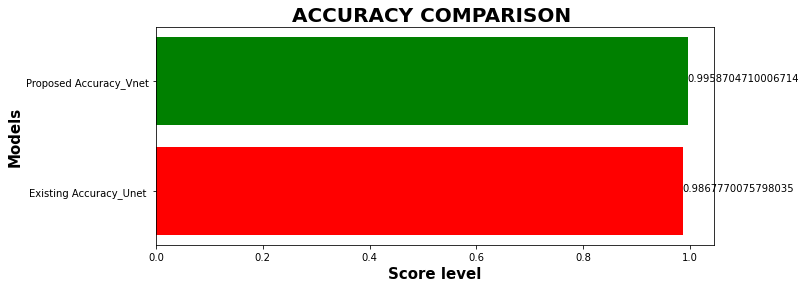

In [39]:
data = {'Existing Accuracy_Unet ':U_net_accuracy,'Proposed Accuracy_Vnet':Vnet_Accuracy}


label = list(data.keys())
model = list(data.values())
color = ['red','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color )

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("ACCURACY COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

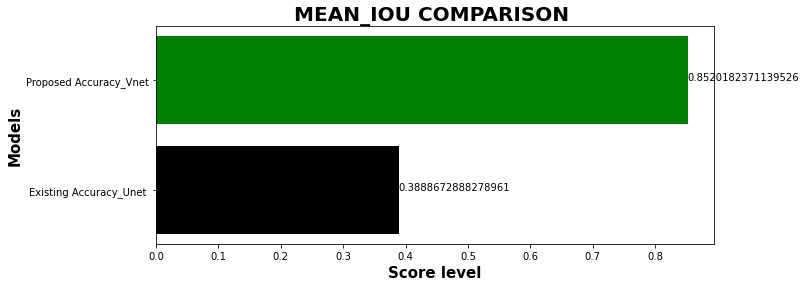

In [40]:
data = {'Existing Accuracy_Unet ':U_net_mean_iou,'Proposed Accuracy_Vnet':Vnet_mean_iou}


label = list(data.keys())
model = list(data.values())
color = ['Black','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color)

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("MEAN_IOU COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

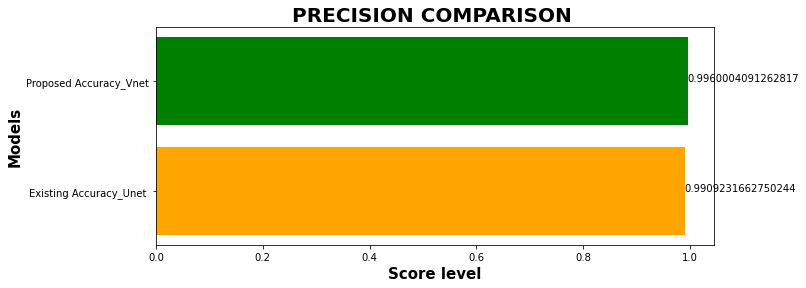

In [41]:
data = {'Existing Accuracy_Unet ':U_net_precision,'Proposed Accuracy_Vnet':Vnet_precision}


label = list(data.keys())
model = list(data.values())
color = ['Orange','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color)

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("PRECISION COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

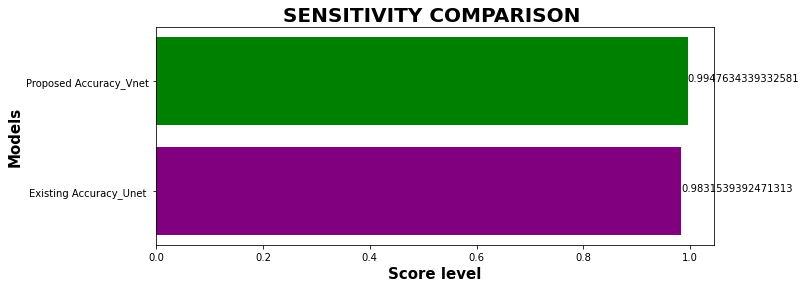

In [42]:
data = {'Existing Accuracy_Unet ':U_net_sensitivity,'Proposed Accuracy_Vnet':Vnet_sensitivity}


label = list(data.keys())
model = list(data.values())
color = ['purple','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color)

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("SENSITIVITY COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

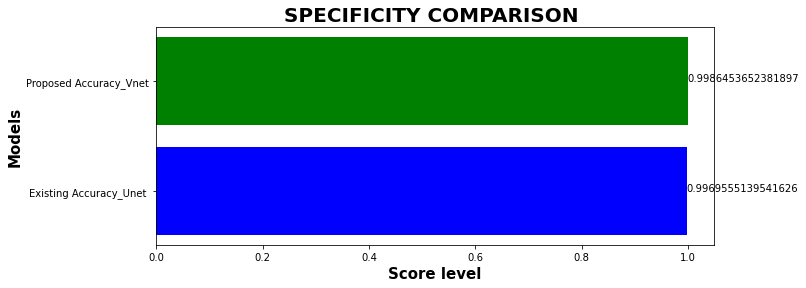

In [43]:
data = {'Existing Accuracy_Unet ':U_net_specificity,'Proposed Accuracy_Vnet':Vnet_specificity}


label = list(data.keys())
model = list(data.values())
color = ['blue','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color)

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("SPECIFICITY COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()

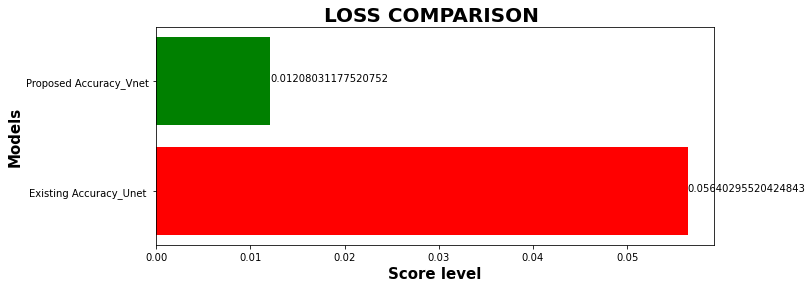

In [44]:
data = {'Existing Accuracy_Unet ':U_net_Loss,'Proposed Accuracy_Vnet':Vnet_Loss}


label = list(data.keys())
model = list(data.values())
color = ['red','green']  
fig = plt.figure(figsize = (10, 4))

plt.barh(label, model, color =color)

for index, value in enumerate(model):
    plt.text(value, index,
             str(value))
    
plt.xlabel("Score level",fontweight ="bold",fontsize=15)
plt.ylabel("Models",fontweight ="bold",fontsize=15)
plt.title("LOSS COMPARISON ",fontweight ="bold",fontsize=20)
plt.show()